__Dataset__

- 60.000 data points
- Each data point -> Event name and description
- Classes:
    - Primary class
    - Secundary class, related to the Primary
    - e.g. Sport -> Football, Sport -> Basketball
- There is class imbalance
- Some classes are incorrectly assigned -> Noise

__Problem__

Multi-label / Multi-class classification problem with levels (Hierarchical Classification)

__Metrics__

All classes have the same importance -> Accuracy


    
    

# 0. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import re

In [ ]:
raw_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PFM/data/data.csv", encoding='utf-8').drop('Unnamed: 0', axis=1)

In [ ]:
raw_data.head()

,title,description,taxonomy,subtaxonomy
0,London Dungeon LATES with Cocktail,"Lates mashes up theatre, special effects and i...",273,275
1,Drumchapel & West Winterfest Fireworks,Don't miss Drumchapel's annual fireworks extra...,273,275
2,MEGALAND 2019,MEGALAND 2019 in the SimÃ³n Bolivar Park. Live...,173,201
3,Extravaganza,It's Extravaganza time at Ferrymead Heritage P...,273,275
4,A Nightmare on Duddell's Street,"Disco Bao is back, this time with a freaky twi...",173,267


In [ ]:
raw_data.shape

(59879, 4)

# 1. Class Distribution

In [ ]:
# missing values
raw_data.isnull().sum()

title              0
description    12702
taxonomy           0
subtaxonomy        0
dtype: int64

In [ ]:
def plot_class_distribution(series, title, percentage=True):
    """
    Plot distribution of classes from a Pandas Series.
    """
    primary_class = series.map(lambda x: 'Class ' + str(x))
    primary_class_proportions = (primary_class.value_counts() / primary_class.shape[0]) * 100

    primary_class.value_counts().plot(
        kind='bar',
        figsize=(11,6),
        color='blue',
        title=title,
        ylabel='Count',
        rot=45
    )

    if percentage:
      for i, perc in enumerate(primary_class_proportions):
          x_offset = i + 1 -1.3
          height = primary_class.value_counts()[i] + 50
          plt.annotate(str(round(perc, 2)) + "%", (x_offset, height), fontsize=12)
      i = 0

    plt.legend()
    plt.show();

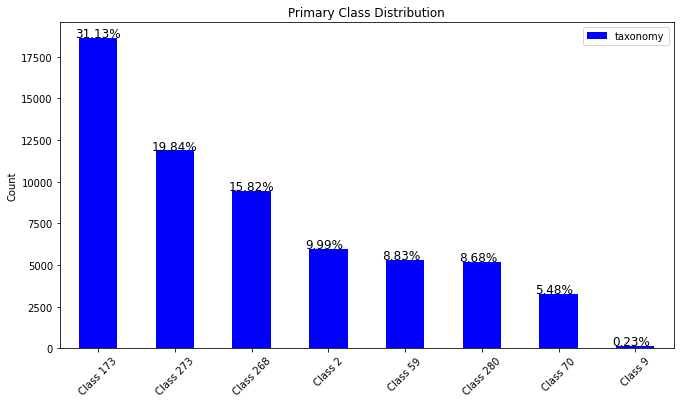

In [ ]:
plot_class_distribution(raw_data['taxonomy'], title='Primary Class Distribution')

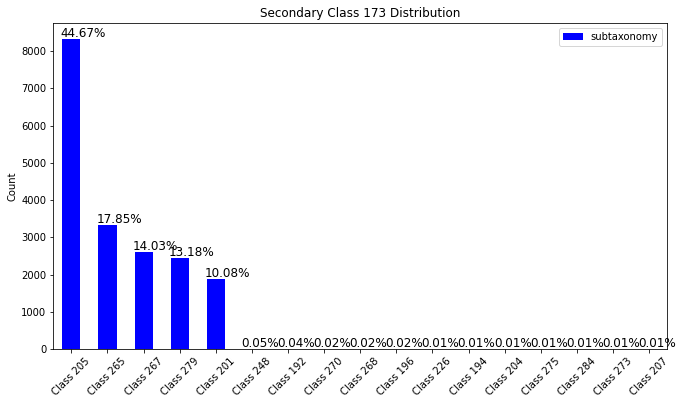

In [ ]:
plot_class_distribution(raw_data.loc[raw_data['taxonomy'] == 173, 'subtaxonomy'], title='Secondary Class 173 Distribution')

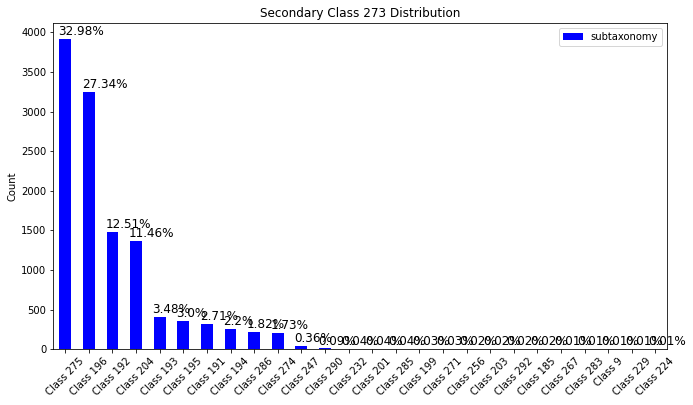

In [ ]:
plot_class_distribution(raw_data.loc[raw_data['taxonomy'] == 273, 'subtaxonomy'], title='Secondary Class 273 Distribution', percentage=True)

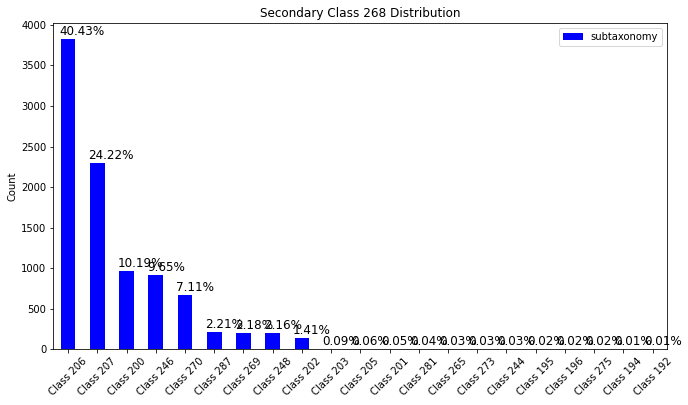

In [ ]:
plot_class_distribution(raw_data.loc[raw_data['taxonomy'] == 268, 'subtaxonomy'], title='Secondary Class 268 Distribution')

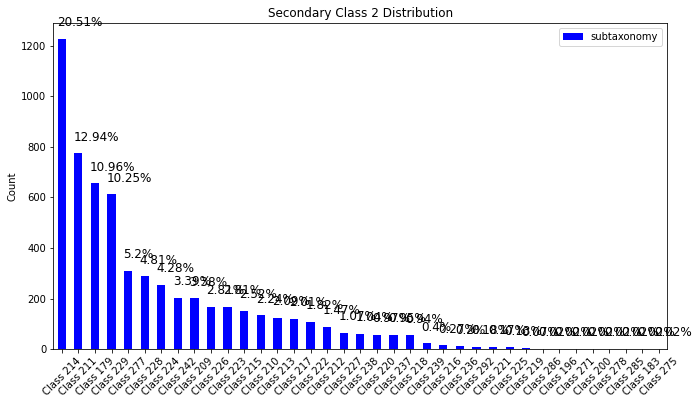

In [ ]:
plot_class_distribution(raw_data.loc[raw_data['taxonomy'] == 2, 'subtaxonomy'], title='Secondary Class 2 Distribution', percentage=True)

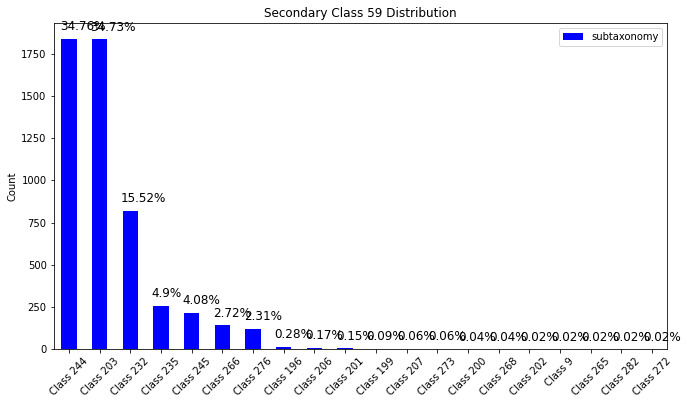

In [ ]:
plot_class_distribution(raw_data.loc[raw_data['taxonomy'] == 59, 'subtaxonomy'], title='Secondary Class 59 Distribution', percentage=True)

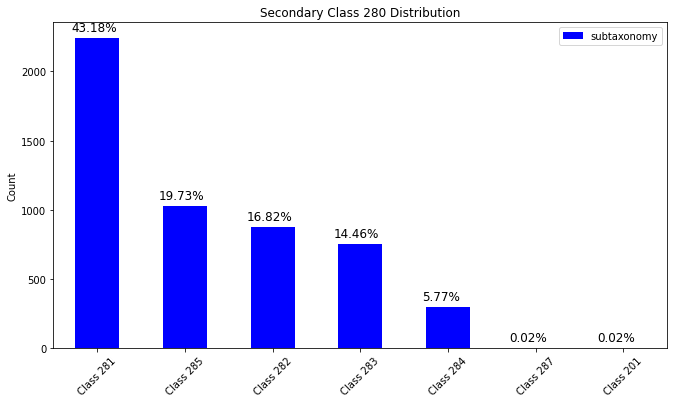

In [ ]:
plot_class_distribution(raw_data.loc[raw_data['taxonomy'] == 280, 'subtaxonomy'], title='Secondary Class 280 Distribution', percentage=True)

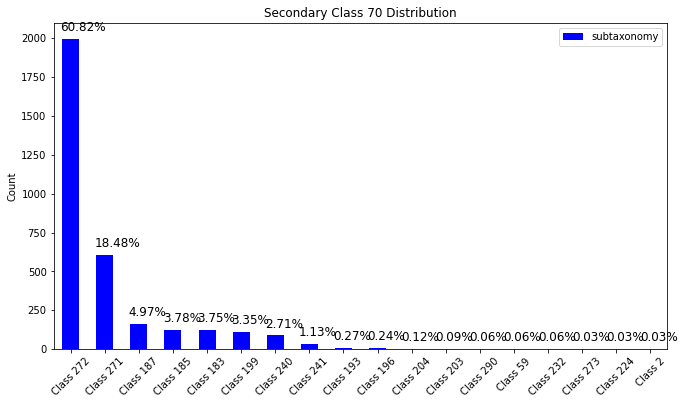

In [ ]:
plot_class_distribution(raw_data.loc[raw_data['taxonomy'] == 70, 'subtaxonomy'], title='Secondary Class 70 Distribution', percentage=True)

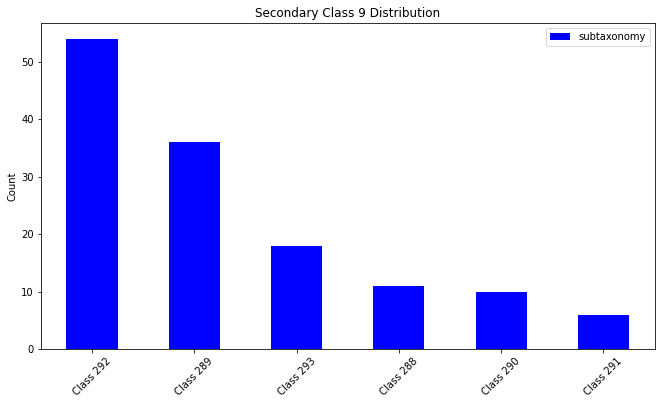

In [ ]:
plot_class_distribution(raw_data.loc[raw_data['taxonomy'] == 9, 'subtaxonomy'], title='Secondary Class 9 Distribution', percentage=False)

**Notes**

<u>Primary Class</u>

- 8 unique classes
- Class imbalance
- Class 173 is the most represented class with 31.13% of the data points belonging to it
- Class 9 is the least represented class with only 0.23% of the data points belonging to it

<u>Secondary Classes</u>

- Some of the secondary classes represent less than 1% of the primary classes. We would argue that this is noise derived from incorrect labeling.

# 3. Multi-class Classification Problem: Primary Class -> Target is only `taxonomy`

train, val and test sets (See train_test_sets.ipynb):
- train_v0.csv: 70% of the dataset
- val_v0.csv: 15% of the dataset
- test_v0.csv: 15% of the dataset

The dataset has been splitted using stratification to keep the class distribution.


In [ ]:
train = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/PFM/data/train_v0.csv",
    index_col=0,
    encoding='utf-8'
)
train.head()

,title,description,taxonomy
10525,Bernina Accessoireag,Meet the Bernina accessories:\n* By a Bernina ...,273
19671,ABC iPad - Like a computer and even more,Every Thursday and Sunday from 11 to 12\nA cou...,70
37172,Meisterkonzert,NaN,173
43220,GZA,The legendary founder and leader of Wu-Tang Cl...,173
6905,Little BIG City,Best of Berlin - from 'CafÃ© Achteck' over the...,273


## 3.1. EDA

## 3.1. Class distribution in training set

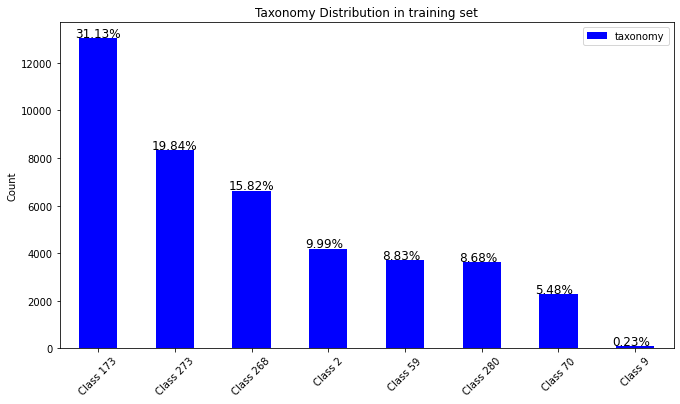

In [ ]:
plot_class_distribution(train['taxonomy'], title='Taxonomy Distribution in training set')

In [ ]:
# display some examples belonging to class 9
for row in train.loc[train['taxonomy'] == 9, ['title', 'description']][:5].itertuples():
  print(row[1])
  print(row[2])
  print("#######################")

Priority Access: Barcelona Sagrada Familia Tour
Duration: 90 minutes (approx.)

Visit La Sagrada Familia in Barcelona on a 1.5-hour skip-the-line tour! With a knowledgeable local guide, head straight past the cathedralâ€™s long entrance lines to learn all about the UNESCO-listed cathedral and its charismatic creator: Antoni Gaudi. After exploring the monument, visit the onsite La Sagrada Familia Museum to see an array of cathedral artifacts.

Select a start time to suit your schedule, and then meet your guide in central Barcelona. Walk straight past the long entrance lines, which are often in excess of two hours long, to Gaudiâ€™s Gothic masterpiece: La Sagrada Familia. After skipping the line, set off to explore Barcelonaâ€™s attention-grabbing church on a comprehensive walking tour. Listed as a UNESCO World Heritage site, La Sagrada Familia is consecrated and was proclaimed a minor basilica by Pope Benedict XVI. Learn all about its fascinating history from your guide, and hear how Ga

Class 9 represents events such as tranfers, vouchers or tickers for activities, etc.

## 3.2. Text data

Inspect text data to work out cleaning requirements.

In [ ]:
for i in range(25):
  i = random.randint(0, 40000)
  row = train.iloc[i]
  print(f"Title:\n{row['title']}")
  print(f"Description:\n{row['description']}")
  print("________________________________________________")

Title:
Danna Paola
Description:
nan
________________________________________________
Title:
Elvis Tribute Night
Description:
Mark Anthony is internationally known and recognised by Elvis Presley Enterprises as one of the top Elvis Tribute Artist in the world! He has won numerous awards and contests and will be performing in Portsmouth's Gaiety Bar on south Parade Pier.

Make sure you book your tickets now for a fun-filled evening with the King of King tribute acts.
________________________________________________
Title:
Beijing Peking Opera Famous Stage Concert
Description:
Purchase notice: Restricted purchase instructions: 6 purchases per seat Type of seat: Please press the seat corresponding to the ticket, orderly check in. Children's admission reminder: Admission of tickets over 1.2 meters, no admission below 1.2 meters
Prohibited items: food, beverage, camera, charging treasure, lighter, etc. Physical ticket: This project supports admission by physical ticket and supports the follo

### Preprocessing and cleaning

**1. Text Cleaning**
1. Remove symbols derived from formatted strings
2. Remove symbols derived from translation from spanish to english -> Approach: if the word contains a symbols, remove.
3. Remove punctuation
4. Remove brackets and parentheses
5. Remove email addresses or links
6. Remove numbers

**2. Missing descriptions or titles**
1. Check number of missing descriptions or title and drop
2. Explore lenghts of titles and description to work out how to join them and how many words should be considered

**3. Text Processing**
1. Try different approaches to find the most informative parts of the text


#### 1. Cleaning

In [ ]:
def is_ascii(w):
  try:
    w.encode("ascii")
    return True
  except UnicodeEncodeError:
    return False

In [ ]:
def text_cleaning(text):
  """
  Clean text from symbols, punctuation, etc.

  Parameters:
  -----------
  text: string, text data
  
  Returns:
  --------
  cleaned_text: string, cleaned text data
  """
  # remove string formatting '\n' or '\t'
  tmp_text = re.sub(r'\n+', '. ', text)
  tmp_text = re.sub(r'\t+', '. ', text)
  # remove words with non-ascii characters
  tmp_text = " ".join([word for word in tmp_text.split() if is_ascii(word)])
  # remove email address
  tmp_text = " ".join([word for word in tmp_text.split() if not word.startswith("@")])
  # remove urls
  tmp_text = re.sub(r'http\S+', '', tmp_text, flags=re.MULTILINE)
  tmp_text = re.sub(r'www\S+', '', tmp_text, flags=re.MULTILINE)
  # remove punctuation but . (to split sentences)
  cleaned_text = re.sub('[^A-Za-z.,]+', ' ', tmp_text)
  # lowercase
  cleaned_text = cleaned_text.lower()

  return cleaned_text

In [ ]:
print(train.iloc[5, 1])
text_cleaning(train.iloc[5, 1])

With Helena Attlee and Rachel Roddy.


'with helena attlee and rachel roddy.'

In [ ]:
print(train.iloc[9, 1], "\n__________\n")
text_cleaning(train.iloc[9, 1])

Magdalena Fleitas music festivalThe surroundings of the Planetarium are filled with music and laughter by the hand of Magdalena Fleitas. A unique event to enjoy the summer and approach, in a pedagogical way, music and art to all children and families.

January 21 | Schedule to be confirmed

Surroundings of the Planetarium (Av. Y Sarmiento and Belisario RoldÃ¡n) 
__________



'magdalena fleitas music festivalthe surroundings of the planetarium are filled with music and laughter by the hand of magdalena fleitas. a unique event to enjoy the summer and approach, in a pedagogical way, music and art to all children and families. january schedule to be confirmed surroundings of the planetarium av. y sarmiento and belisario'

In [ ]:
print(train.iloc[500, 1], "\n__________\n")
text_cleaning(train.iloc[500, 1])

The Festival NOS Primavera Sound presents a new ticket that includes VIP access with gastronomic experience in the renowned restaurant "O Gaveto" in Matosinhos.

NOS Primavera Sound is back in the City Park June 6-8. The location next to the beach invites you to have a quiet and leisurely lunch before entering the grounds and enjoying the best fish and seafood there.

On June 8, Saturday, it will be possible to take the experience of NOS Primavera Sound beyond the festival grounds and start early, with an inviting and irresistible rice lunch of lavagante and a unique wine tasting, given by those who know better and promote the Douro region.

In what promises to be a truly different experience, NOS Primavera Sound has joined the renowned restaurant "O Gaveto" and created the ticket NOS Primavera Sound with Rice of the Same that includes a gastronomic experience, among others, to experience the famous rice of flamboyant, familiar to the locals and increasingly applauded by enthusiastic a

'the festival nos primavera sound presents a new ticket that includes vip access with gastronomic experience in the renowned restaurant o gaveto in matosinhos. nos primavera sound is back in the city park june . the location next to the beach invites you to have a quiet and leisurely lunch before entering the grounds and enjoying the best fish and seafood there. on june , saturday, it will be possible to take the experience of nos primavera sound beyond the festival grounds and start early, with an inviting and irresistible rice lunch of lavagante and a unique wine tasting, given by those who know better and promote the douro region. in what promises to be a truly different experience, nos primavera sound has joined the renowned restaurant o gaveto and created the ticket nos primavera sound with rice of the same that includes a gastronomic experience, among others, to experience the famous rice of flamboyant, familiar to the locals and increasingly applauded by enthusiastic and influen

#### 2. Missing descriptions or titles

In [ ]:
# check number of missing descriptions or titles
train.isnull().sum()

title             0
description    8930
taxonomy          0
dtype: int64

In [ ]:
# proportion of missing descriptions
str(round((train['description'].isnull().sum() / train.shape[0])*100, 2)) + "%"

'21.31%'

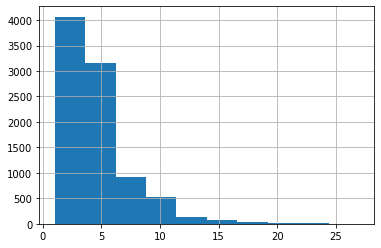

In [ ]:
train[train['description'].isnull()]['title'].map(lambda x: len(x.split())).hist();

Most of the titles with missing description are shorter than 5 words and therefore won't be very informative. Although they represent the 21.31% of the training set, I will not use them to train the model in a first attempt.

In [ ]:
# drop rows with missing descriptions
no_mv_train = train.dropna(axis=0)

In [ ]:
# clean text
cleaned_train = no_mv_train.copy()
cleaned_train['title'] = cleaned_train['title'].map(text_cleaning)
cleaned_train['description'] = cleaned_train['description'].map(text_cleaning)
cleaned_train.head()

,title,description,taxonomy
10525,bernina accessoireag,meet the bernina accessories by a bernina expe...,273
19671,abc ipad like a computer and even more,every thursday and sunday from to a course to ...,70
43220,gza,the legendary founder and leader of wu tang cl...,173
6905,little big city,best of berlin from achteck over the wall to t...,273
46483,a foodwriting masterclass,with helena attlee and rachel roddy.,273


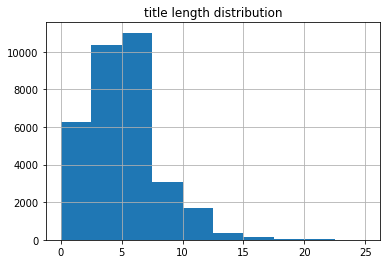

In [ ]:
# title length distribution
cleaned_train['title'].map(lambda x: len(x.split())).hist()
plt.title("title length distribution");

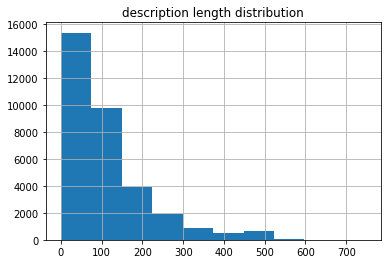

In [ ]:
cleaned_train['description'].map(lambda x: len(x.split())).hist()
plt.title("description length distribution");

The distributions are right-skewed. But I will not use the whole description, limiting the number of words.

#### 3. Text processing

**Approach 1**: First 2 sentences of the text + Last 2 sentences

In [ ]:
def text_preprocessing_a1(text):
  """
  Approach 1: Join first 2 sentences with last 2 sentences of the text.
  
  Parameters:
  -----------
  text: string, text data
  
  Returns:
  --------
  preprocessed_text: string, preprocessed text data
  """
  # sentence tokenize based on '. '
  sentences = text.split('. ')
  # get 2 first and 2 last sentences
  if len(sentences) >= 4:
    preprocessed_text = ". ".join(text.split('. ')[:2] + text.split('. ')[-2:])
    return preprocessed_text
  # if there are not 4 sentences, return full text
  else:
    preprocessed_text = text
    return preprocessed_text

In [ ]:
preprocessed_train = cleaned_train.drop('title', axis=1).copy()
preprocessed_train['description'] = cleaned_train['description'].map(text_preprocessing_a1)
preprocessed_train = preprocessed_train.rename(columns={'description': 'text'})

In [ ]:
preprocessed_train.shape

(32985, 2)

In [ ]:
preprocessed_train.head()

,text,taxonomy
10525,meet the bernina accessories by a bernina expe...,273
19671,every thursday and sunday from to a course to ...,70
43220,the legendary founder and leader of wu tang cl...,173
6905,best of berlin from achteck over the wall to t...,273
46483,with helena attlee and rachel roddy.,273


In [ ]:
preprocessed_train.iloc[800, 0]

'kidd keo one of the most admired and respected artists of the moment, with his trap music is getting important recognitions, practically since its inception has been highlighted as one of the most important artists of the genre. in a year full of successes, sold out concerts, tours in latin america, los angeles usa, is closing a very fruitful year on an artistic and personal level, surpassing its records of downloads on all platforms, taking its trap music around the whole world, full of a wide range of proposals and demand for brands very recognized in the industry. on february , , he will visit at one of the stops on his world tour.'

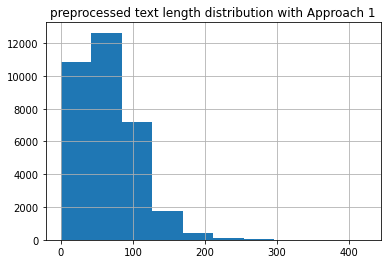

In [ ]:
preprocessed_train['text'].map(lambda x: len(x.split())).hist()
plt.title("preprocessed text length distribution with Approach 1");

In [ ]:
# only keep instances with < 210 tokens
preprocessed_train = preprocessed_train[preprocessed_train['text'].map(lambda x: len(x.split())) < 210]

In [ ]:
def encode_taxonomy(taxonomy):
  """
  Label encode taxonomy for training distilbert.

  Parameters:
  -----------
  taxonomy: int, taxonomy class
  
  Returns:
  --------
  encoding: int, encoded taxonomy class
  """
  encoding_dict = {2: 0, 9: 1, 59: 2, 70: 3, 173: 4, 268: 5, 273: 6, 280: 7}
  encoding = encoding_dict[taxonomy]

  return encoding

In [ ]:
def preprocessing_a1(df):
  """
  Cleaning and preprocessing following approach 1.

  Parameters:
  -----------
  df: Pandas DataFrame, df with `title`, `description` and `taxonomy`
  
  Returns:
  --------
  preprocessed_df: Pandas DataFrame, df with `text` (preprocessed text) and `taxonomy`
  """
  # drop rows with missing descriptions and drop title
  cleaned_df = df.dropna(axis=0).drop('title', axis=1)
  # clean description
  cleaned_df['description'] = cleaned_df['description'].map(text_cleaning)
  # preprocess description
  preprocessed_df = cleaned_df.copy()
  preprocessed_df['description'] = cleaned_df['description'].map(text_preprocessing_a1)
  preprocessed_df = preprocessed_df.rename(columns={'description': 'text'})
  # keep examples with less than 210 tokens
  preprocessed_df = preprocessed_df[preprocessed_df['text'].map(lambda x: len(x.split())) < 210]

  # encode taxonomy
  preprocessed_df['taxonomy'] = preprocessed_df['taxonomy'].map(encode_taxonomy)

  return preprocessed_df

**Approach 2**: First 4 sentences of the text + Last 4 sentences

In [ ]:
def text_preprocessing_a2(text):
  """
  Approach 2: Join first 4 sentences with last 4 sentences of the text.
  
  Parameters:
  -----------
  text: string, text data
  
  Returns:
  --------
  preprocessed_text: string, preprocessed text data
  """
  # sentence tokenize based on '. '
  sentences = text.split('. ')
  # get 2 first and 2 last sentences
  if len(sentences) >= 8:
    preprocessed_text = ". ".join(text.split('. ')[:4] + text.split('. ')[-4:])
    return preprocessed_text
  # if there are not 8 sentences, return full text
  else:
    preprocessed_text = text
    return preprocessed_text

In [ ]:
preprocessed_train = cleaned_train.drop('title', axis=1).copy()
preprocessed_train['description'] = cleaned_train['description'].map(text_preprocessing_a2)
preprocessed_train = preprocessed_train.rename(columns={'description': 'text'})

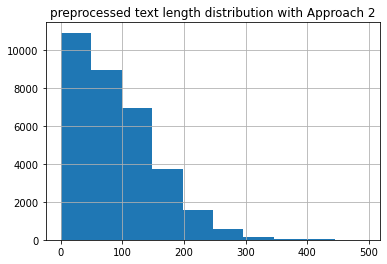

In [ ]:
preprocessed_train['text'].map(lambda x: len(x.split())).hist()
plt.title("preprocessed text length distribution with Approach 2");

In [ ]:
def preprocessing_a2(df):
  """
  Cleaning and preprocessing following approach 2.

  Parameters:
  -----------
  df: Pandas DataFrame, df with `title`, `description` and `taxonomy`
  
  Returns:
  --------
  preprocessed_df: Pandas DataFrame, df with `text` (preprocessed text) and `taxonomy`
  """
  # drop rows with missing descriptions and drop title
  cleaned_df = df.dropna(axis=0).drop('title', axis=1)
  # clean description
  cleaned_df['description'] = cleaned_df['description'].map(text_cleaning)
  # preprocess description
  preprocessed_df = cleaned_df.copy()
  preprocessed_df['description'] = cleaned_df['description'].map(text_preprocessing_a2)
  preprocessed_df = preprocessed_df.rename(columns={'description': 'text'})
  # keep examples with less than 210 tokens
  preprocessed_df = preprocessed_df[preprocessed_df['text'].map(lambda x: len(x.split())) < 300]

  # encode taxonomy
  preprocessed_df['taxonomy'] = preprocessed_df['taxonomy'].map(encode_taxonomy)

  return preprocessed_df

#4. Preprocessing and cleaning for `taxonomy 173`

In [ ]:
preprocessed_train[preprocessed_train['taxonomy'] == 173]

,text,taxonomy
43220,the legendary founder and leader of wu tang cl...,173
40328,a show that brings together great exponents of...,173
50959,"one more year, tsunami becomes one of the fest...",173
26401,"the reverse side receives dj costa, thursday, ...",173
58952,homenagem brasileira to embraces the diversity...,173
...,...,...
12154,cover cup cuc tellez,173
12387,the intered organization organizes this solida...,173
57442,on june nd at the auditorium of the badajoz fa...,173
35996,"a triple threat this march as more reverb, nak...",173


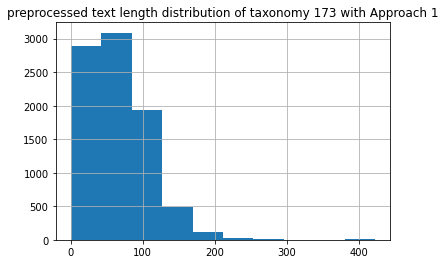

In [ ]:
# length distribution after preprocessing and cleaning
preprocessed_train[preprocessed_train['taxonomy'] == 173]['text'].map(lambda x: len(x.split())).hist()
plt.title("preprocessed text length distribution of taxonomy 173 with Approach 1");

Use max length as 150